## **MODEL TRAINING**

In [1]:
## IMPORTING LIBRARIES
import os
import json
import re, string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import nltk, spacy
import seaborn as sns
import nbformat

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from tqdm import tqdm, tqdm_notebook
from pprint import pprint
tqdm.pandas()


In [2]:
## loading the dataset
New_df = pd.read_csv("../data/labeled_complaints.csv")

In [3]:
## INPUT AND OUPUT DATA
X = New_df['complaint_what_happend']
y = New_df['Topic']

In [4]:
print("Input shape: ",X.shape)
print("output shape: ",y.shape)

Input shape:  (21072,)
output shape:  (21072,)


In [5]:
print(y.value_counts())
print()
print(y.value_counts().index)
print()
print(y.value_counts().values)
print()
print(max(y.value_counts().values))

Topic
0    5196
2    5086
4    4537
1    3909
3    2344
Name: count, dtype: int64

Index([0, 2, 4, 1, 3], dtype='int64', name='Topic')

[5196 5086 4537 3909 2344]

5196


In [6]:
## CHECK THE CLASS IMBALANCE
px.bar(x=y.value_counts().index,y=y.value_counts().values/max(y.value_counts().values),title='Class Imbalance')

- `Not too much class difference`

### LET'S TRY DIFFERENT-DIFFERENT MODEL LIKE
- `LOGISTIC REGRESSION`
- `LINEAR SVC`
- `XGBOOST`

- I HAD ALREADY TRY
    - DECISION TREE
    - RANDOM FOREST 
    - NAIVE BAYES 

    AND THEY NOT PERFOMS WELL AND DUE TO THEM TRAINING TIME IS ALSO TOO MUCH.

In [7]:
## IMPORT REQUIRED LIBRARIES
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
## SPLITTING INTO TRAIN AND TEST DATA
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#### -> **DEFINING MODELS WITH PARAM GRID** 

In [9]:
models = {
    ## LOGISTIC REGRESSION
    'LR': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l1','l2','elasticnet'],
            'clf__solver': ['lbfgs'],
            'clf__class_weight': [None, 'balanced']
        },
        'n_iter': 10
    },

    ## LINEAR SVC
    'LSVC':{
        'model': LinearSVC(),
        'params': {
            'clf__C': [0.01, 0.1, 1, 10],
        },
        'n_iter': 10
    },

    ## XGBOOST
    'XGB':{
        'model': XGBClassifier(
            objective='multi:softprob',   # REQUIRED for multi-class
            eval_metric='mlogloss',
            num_class=y.nunique(),
            use_label_encoder=False,
            tree_method='hist',            # faster
            random_state=42,
            n_jobs=-1
        ),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [3, 5],
            'clf__learning_rate': [0.05, 0.1],
            'clf__gamma': [0, 0.5, 1],
            'clf__subsample': [0.8, 1.0],
            'clf__colsample_bytree': [0.8, 1.0]
        },
        'n_iter': 20
    }
}


In [10]:
# ## EVALUATION FUNCTION

def eval_model(y_true, y_pred, y_proba=None, name="Model"):
    print(f"\n{name} results")
    print("Accuracy:", round(accuracy_score(y_true, y_pred),3))
    print("Precision:", round(precision_score(y_true, y_pred, average='weighted'),3))
    print("Recall:", round(recall_score(y_true, y_pred, average='weighted'),3))
    print("F1:", round(f1_score(y_true, y_pred, average='weighted'),3))

    if y_proba is not None:
        print(
            "ROC AUC:",
            round(roc_auc_score(
                y_true, y_proba,
                average='weighted',
                multi_class='ovr'
            ),3)
        )
    cr = classification_report(y_true, y_pred)
    print(f"Classification Report of {name}, {cr}")
    cm = confusion_matrix(y_true,y_pred)
    print(f"Confusion Matrix of {name}, {cm}")
    labels = sorted(set(y_true))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    disp.plot()



Training LR...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

LR results
Accuracy: 0.916
Precision: 0.916
Recall: 0.916
F1: 0.916
ROC AUC: 0.993
Classification Report of LR,               precision    recall  f1-score   support

           0       0.92      0.92      0.92      1037
           1       0.92      0.91      0.92       819
           2       0.94      0.93      0.93       980
           3       0.89      0.93      0.91       481
           4       0.90      0.88      0.89       898

    accuracy                           0.92      4215
   macro avg       0.91      0.92      0.91      4215
weighted avg       0.92      0.92      0.92      4215

Confusion Matrix of LR, [[959  15  17  12  34]
 [ 15 749   5  17  33]
 [ 19  20 913  12  16]
 [  8  14   5 447   7]
 [ 36  20  34  17 791]]

Training LSVC...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

LSVC results
Accuracy: 0.911
Precision: 0.911
Recall: 0.911
F1: 0.91
Classification Report of LSVC,   

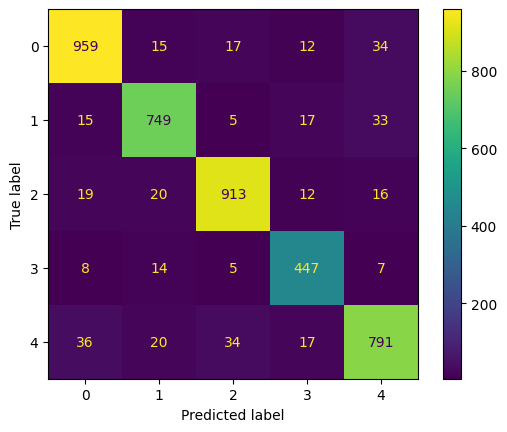

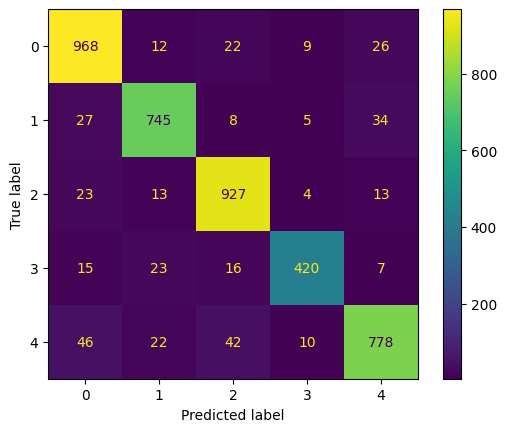

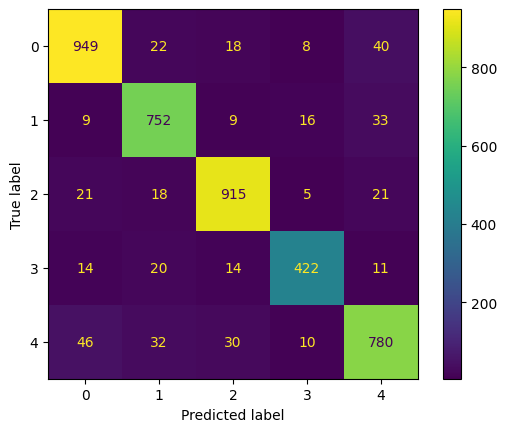

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
Models = {}

for model_name, config in models.items():

    print(f"\nTraining {model_name}...")

    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', config['model'])
    ])

    random_cv = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=config['params'],
        n_iter=config['n_iter'],
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    random_cv.fit(X_train, y_train)

    best_model = random_cv.best_estimator_

    Models[model_name] = best_model

    y_test_pred = best_model.predict(X_test)

    # handle predict_proba safely
    y_test_proba = (
        best_model.predict_proba(X_test)
        if hasattr(best_model, "predict_proba")
        else None
    )

    eval_model(y_test, y_test_pred, y_test_proba, name=model_name)

    results.append({
        'Model': model_name,
        'Best CV F1': random_cv.best_score_,
        'Test F1': f1_score(y_test, y_test_pred, average='weighted')
    })

    print("="*90)
  

In [12]:
Models

{'LR': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                 ('clf',
                  LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                     penalty='l2'))]),
 'LSVC': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                 ('clf', LinearSVC(C=0.1))]),
 'XGB': Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                 ('clf',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=1.0, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric='mlogloss',
                                feature_types=None, feature_weights=None,
                                gamma=1, grow_policy=None, importance_type

In [13]:

for i, j in Models.items():
    print(i)
    print(j)

LR
Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    penalty='l2'))])
LSVC
Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(C=0.1))])
XGB
Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, feature_weights=None,
                               gamma=1, grow_policy=None, importance_type=None,
                   

In [14]:
import pandas as pd

results_df = pd.DataFrame(results).sort_values(
    by='Test F1',
    ascending=False
)

results_df

,Model,Best CV F1,Test F1
0,LR,0.915929,0.915525
1,LSVC,0.908321,0.910318
2,XGB,0.906832,0.905726


## **FINAL TAKE**
- The `LOGISTIC REGRESSION` Performs `Best`. 

- The `LINEAR SVC' & `XGB` Performs `Good`.

- The `RANDOM FOREST`, `DECISION TREE` & `NAIVE BAYES` Not Performs Well. (RUN PREVIOUSLY THAT TIME CODE TAKES 3hr TO EXECUTE)

In [18]:
## USE THE BEST MODEL WITH THE BEST PARAMETER COMBINATION
final_model_pipeline_lr = Models['LR']
final_model_pipeline_lr

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vect', ...), ('tfidf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [15]:
## USE THE BEST MODEL WITH THE BEST PARAMETER COMBINATION
final_model_pipeline_lsvc = Models['LSVC']
final_model_pipeline_lsvc

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vect', ...), ('tfidf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [16]:
## USE THE BEST MODEL WITH THE BEST PARAMETER COMBINATION
final_model_pipeline_xgb = Models['XGB']
final_model_pipeline_xgb

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vect', ...), ('tfidf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


## **SAVE ALL THE THREE MODELS** 

In [70]:
## create the 'data' directory if it doesn't exist
if not os.path.exists('../Artifacts'):
    os.makedirs('../Artifacts')

## USE JOBLIB FOR THIS PURPOSE AS IT IS FAST THAN PICKEL
import joblib

joblib.dump(final_model_pipeline_lr,'../Artifacts/lr_pipeline.pkl')
joblib.dump(final_model_pipeline_lsvc,'../Artifacts/lsvc_pipeline.pkl')
joblib.dump(final_model_pipeline_xgb,'../Artifacts/xgb_pipeline.pkl')

['../Artifacts/xgb_pipeline.pkl']

## **LOAD THIS FINAL MODEL PIPELINE AND THEN TEST WITH A CUSTOM INPUT**

In [21]:
df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [71]:
## LOADING THE PIPELINE
model = joblib.load('../Artifacts/lr_pipeline.pkl')

In [25]:
predicted_labels = model.predict(df_complaints['complaints'])

In [26]:
predicted_labels

array([2, 1, 0, 4, 0, 0], dtype=int64)

In [27]:
Topic_names = {
    0: 'Bank Account Services',
    1: 'Credit card or prepaid card',
    2: 'Mortage/Loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others'
}


In [28]:
predicted_topic = [Topic_names[label] for label in predicted_labels]

In [29]:
predicted_topic

['Mortage/Loan',
 'Credit card or prepaid card',
 'Bank Account Services',
 'Others',
 'Bank Account Services',
 'Bank Account Services']

In [30]:
df_complaints['complaint_label'] = predicted_topic

In [31]:
df_complaints

,complaints,complaint_label
0,I can not get from chase who services my mortg...,Mortage/Loan
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account Services
3,"Yesterday, I received a fraudulent email regar...",Others
4,What is the procedure to know my CIBIL score?,Bank Account Services
5,I need to know the number of bank branches and...,Bank Account Services


In [32]:
proba = model.predict_proba(df_complaints['complaints'])


In [33]:
confidence = proba.max(axis=1)
df_complaints['confidence_score'] = confidence.round(2)

In [34]:
df_complaints

,complaints,complaint_label,confidence_score
0,I can not get from chase who services my mortg...,Mortage/Loan,0.96
1,The bill amount of my credit card was debited ...,Credit card or prepaid card,0.90
2,I want to open a salary account at your downto...,Bank Account Services,0.76
3,"Yesterday, I received a fraudulent email regar...",Others,0.60
4,What is the procedure to know my CIBIL score?,Bank Account Services,0.27
5,I need to know the number of bank branches and...,Bank Account Services,0.76


## **SAVE THE MODEL WITH THE LABEL MAP**

In [73]:
artifact_lr = {
    "model": final_model_pipeline_lr,
    "label_map": {
        0: 'Account Services',
        1: 'Others',
        2: 'Mortgage/Loan',
        3: 'Credit card or prepaid card',
        4: 'Theft/Dispute Reporting'
    }
}

artifact_lsvc = {
    "model": final_model_pipeline_lsvc,
    "label_map": {
        0: 'Account Services',
        1: 'Others',
        2: 'Mortgage/Loan',
        3: 'Credit card or prepaid card',
        4: 'Theft/Dispute Reporting'
    }
}

artifact_xgb = {
    "model": final_model_pipeline_xgb,
    "label_map": {
        0: 'Account Services',
        1: 'Others',
        2: 'Mortgage/Loan',
        3: 'Credit card or prepaid card',
        4: 'Theft/Dispute Reporting'
    }
}

## create the 'data' directory if it doesn't exist
if not os.path.exists('../Artifacts'):
    os.makedirs('../Artifacts')

joblib.dump(artifact_lr, "../Artifacts/lr_artifact.pkl")
joblib.dump(artifact_lsvc, "../Artifacts/lsvc_artifact.pkl")
joblib.dump(artifact_xgb, "../Artifacts/xgb_artifact.pkl")


['../Artifacts/xgb_artifact.pkl']

## TRYING WITH XGB

In [36]:
final_model_pipeline_xgb

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vect', ...), ('tfidf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [37]:
df_complaints_xgb = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints_xgb

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [39]:
predicted_label_xgb = final_model_pipeline_xgb.predict(df_complaints_xgb['complaints'])
predicted_label_xgb

array([2, 1, 0, 4, 0, 0], dtype=int64)

In [40]:
predicted_topic_xgb = [Topic_names[label] for label in predicted_label_xgb]

In [41]:
df_complaints_xgb['labels_xgb'] = predicted_topic_xgb

In [42]:
proba_xgb = final_model_pipeline_xgb.predict_proba(df_complaints_xgb['complaints'])


In [43]:
confidence_xgb = proba_xgb.max(axis=1)
df_complaints_xgb['confidence_score_xgb'] = confidence_xgb.round(2)

In [44]:
df_complaints_xgb

,complaints,labels_xgb,confidence_score_xgb
0,I can not get from chase who services my mortg...,Mortage/Loan,1.00
1,The bill amount of my credit card was debited ...,Credit card or prepaid card,0.99
2,I want to open a salary account at your downto...,Bank Account Services,0.98
3,"Yesterday, I received a fraudulent email regar...",Others,0.67
4,What is the procedure to know my CIBIL score?,Bank Account Services,0.49
5,I need to know the number of bank branches and...,Bank Account Services,0.91


## TRYING WITH LSVC

In [45]:
final_model_pipeline_lsvc

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vect', ...), ('tfidf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [57]:
df_complaints_lsvc = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints_lsvc

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [58]:
predicted_label_lsvc = final_model_pipeline_lsvc.predict(df_complaints_lsvc['complaints'])
predicted_label_lsvc

array([2, 1, 0, 4, 0, 0], dtype=int64)

In [59]:
predicted_topic_lsvc = [Topic_names[label] for label in predicted_label_lsvc]

In [60]:
df_complaints_lsvc['labels_lsvc'] = predicted_topic_lsvc

In [62]:
df_complaints_lsvc

,complaints,labels_lsvc
0,I can not get from chase who services my mortg...,Mortage/Loan
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account Services
3,"Yesterday, I received a fraudulent email regar...",Others
4,What is the procedure to know my CIBIL score?,Bank Account Services
5,I need to know the number of bank branches and...,Bank Account Services


In [64]:
## AS LINEAR SVC DO NOT HAVE THE PREDICT PROBA SO HAVE TO USE DECISION FUNCTION TO GET THE CONFIDENCE SCORE 
X_vec = final_model_pipeline_lsvc[:-1].transform(
    df_complaints_lsvc['complaints']
)

decision_scores = final_model_pipeline_lsvc.named_steps['clf'].decision_function(X_vec)


In [65]:
from scipy.special import softmax

confidence_lsvc = softmax(decision_scores,axis=1).max(axis=1)

In [66]:
confidence_lsvc

array([0.68298937, 0.54517107, 0.45331675, 0.36452165, 0.25041684,
       0.47751356])

In [67]:
df_complaints_lsvc['confidence_score_lsvc'] = confidence_lsvc.round(2)

In [68]:
df_complaints_lsvc

,complaints,labels_lsvc,confidence_score_lsvc
0,I can not get from chase who services my mortg...,Mortage/Loan,0.68
1,The bill amount of my credit card was debited ...,Credit card or prepaid card,0.55
2,I want to open a salary account at your downto...,Bank Account Services,0.45
3,"Yesterday, I received a fraudulent email regar...",Others,0.36
4,What is the procedure to know my CIBIL score?,Bank Account Services,0.25
5,I need to know the number of bank branches and...,Bank Account Services,0.48
